# Загрузка модели

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained("ai-sage/GigaChat-20B-A3B-base", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("ai-sage/GigaChat-20B-A3B-base", trust_remote_code=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

/home/jovyan/.mlspace/envs/ellur4n-moe/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 9/9 [01:27<00:00,  9.73s/it]


DeepseekForCausalLM(
  (model): DeepseekModel(
    (embed_tokens): Embedding(128256, 2048, padding_idx=2)
    (layers): ModuleList(
      (0): DeepseekDecoderLayer(
        (self_attn): DeepseekSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): DeepseekRotaryEmbedding()
        )
        (mlp): DeepseekMLP(
          (gate_proj): Linear(in_features=2048, out_features=14336, bias=False)
          (up_proj): Linear(in_features=2048, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): DeepseekRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): DeepseekRMSNorm((2048,), 

# Модифицируем MoE роутеры

In [2]:
def get_gate(layer):
    if hasattr(layer, "mlp"):
        return layer.mlp.gate
    elif hasattr(layer, "block_sparse_moe"):
        return layer.block_sparse_moe.gate
    else:
        raise Exception("not implemented")
        
def get_moe_layers(model):
    for layer_id in range(len(model.base_model.layers)):
        layer = model.base_model.layers[layer_id]
        if hasattr(layer, "block_sparse_moe") or (hasattr(layer, "mlp") and hasattr(layer.mlp, "gate")):
            yield layer_id, layer


In [3]:
from transformers import set_seed as set_seed_f


def generate_text(
    prompt,
    model,
    tokenizer,
    max_length=None,
    max_new_tokens=None,
    repetition_penalty=1.07,
    print_text=True,
    truncation=False,
    context_length=None,
):

    t = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=truncation,
        max_length=context_length,
    )

    input_ids = t.input_ids[:, :context_length].to("cuda")
    attention_mask = t.attention_mask[:, :context_length].to("cuda")

    torch.cuda.empty_cache()
    gen_params = {}
    with torch.no_grad():
        if max_length:
            gen_params["max_length"] = max_length
        else:
            gen_params["max_new_tokens"] = max_new_tokens
        gen_params["repetition_penalty"] = repetition_penalty
        gen_params["input_ids"] = input_ids
        gen_params["attention_mask"] = attention_mask
        gen_params["do_sample"] = False

        gen_params.update(
            dict(
                use_cache=True,
                return_dict_in_generate=True,
            )
        )

        out = model.generate(**gen_params, pad_token_id=tokenizer.eos_token_id)

    generated_text = tokenizer.decode(out["sequences"][0][input_ids.shape[1]:])

    if print_text:
        print(
            f"prompt={prompt}", f"generated_text={generated_text}", sep="\n\n"
        )
        print("=======================================")
    return generated_text

In [4]:
import math
import torch.nn.functional as F
from torch import nn


def apply_logits_func(logits_func, logits, control_vector, control_coef):
    logits_norm = torch.norm(logits[0], p=2, dim=-1, keepdim=True)
    control_vector_norm = torch.norm(control_vector, p=2, dim=-1, keepdim=True)
    logits = logits[0]

    if logits_func == "add":
        logits = logits + control_vector * control_coef
    elif logits_func == "add and scale norms":
        norm_coef = logits_norm / control_vector_norm
        logits = (logits + control_vector * control_coef *
                  torch.max(logits, dim=-1, keepdim=True)[0]) / 2
    elif logits_func == "add and scale norms 2":
        norm_coef = logits_norm / control_vector_norm
        logits = logits + control_vector * control_coef * norm_coef
        new_logits_norm = torch.norm(logits, p=2, dim=-1, keepdim=True)
        logits = logits / new_logits_norm * logits_norm
    elif logits_func == "add and scale norms 3":
        logits = logits + control_vector * control_coef
        new_logits_norm = torch.norm(logits, p=2, dim=-1, keepdim=True)
        logits = logits / new_logits_norm * logits_norm
    elif logits_func == "add and scale norms 4":
        norm_coef = logits_norm / control_vector_norm
        logits = logits + control_vector * control_coef * norm_coef
    elif logits_func == "abs max":
        logits = (logits + control_vector * control_coef *
                  torch.max(torch.abs(logits), dim=-1, keepdim=True)[0]) / 2

    return logits


class NewForward:
    def __init__(self, old_forward, layer_idx):
        self.old_forward = old_forward
        self.layer_idx = layer_idx
        self.control_conf = dict(
            logits_func="default",
            weights_func="default",
            control_coef=0,
            weights_averaging_coef=1,
            leave_prompt_unchanged=False,
            scale_topk_weights=False,
            weights_norm_update_min=0,
            control_matrix=None,
            reduce_over_time=None,
            weights_norm_update_max=None
        )
        self.time = 0

    def new_forward(self, x):
        conf = self.control_conf
        nf_self = self.old_forward.__self__ if hasattr(
            self.old_forward, '__self__') else self.old_forward.args[0]

        bsz, seq_len, h = x.shape

        hidden_states = x.view(-1, h)
        orig_logits = F.linear(x, nf_self.weight, None)
        orig_scores = orig_logits.softmax(dim=-1)
        logits = orig_logits

        orig_topk_idx, orig_topk_weight, aux_loss = self.old_forward(x)

        def return_orig():
            return orig_topk_idx, orig_topk_weight, aux_loss

        if conf["reduce_over_time"] and self.time < conf["reduce_over_time"]:
            control_coef = conf["control_coef"] * \
                (conf["reduce_over_time"] - self.time) / \
                conf["reduce_over_time"]
            self.time += 1
        elif conf["reduce_over_time"]:
            return return_orig()
        else:
            control_coef = conf["control_coef"]

        if conf["control_matrix"] is None or conf["logits_func"] == "default" and conf["weights_func"] == "default":
            return return_orig()

        control_matrix = conf["control_matrix"]
        control_vector = control_matrix[self.layer_idx]

        if torch.sum(control_vector, dim=-1, keepdim=True) <= 1e-9:
            return return_orig()

        logits = apply_logits_func(
            conf["logits_func"], logits, control_vector, control_coef)
        scores = logits.softmax(dim=-1)

        if conf["leave_prompt_unchanged"] and logits.shape[0] > 1:
            self.time -= 1
            return return_orig()

        orig_scores_sum = torch.sum(scores, dim=-1, keepdim=True)

        control_matrix_sum = torch.sum(control_vector, dim=-1, keepdim=True)
        if conf["weights_func"] == "add" and control_matrix_sum.item() > 0:
            control_vector_sum = torch.sum(
                control_vector, dim=-1, keepdim=True)
            scores = scores * (1 - control_coef) + control_coef * \
                control_vector / control_vector_sum

        if conf["weights_func"] == "set" and control_matrix_sum.item() > 0:
            scores = control_vector * control_coef

        if conf["weights_norm_update_min"] and torch.sum(torch.abs(orig_scores - scores)) < conf["weights_norm_update_min"]:
            return return_orig()

        if conf["weights_norm_update_max"] and torch.sum(torch.abs(orig_scores - scores)) > conf["weights_norm_update_max"]:
            scores = orig_scores + \
                (scores - orig_scores) * \
                conf["weights_norm_update_max"] / \
                torch.sum(torch.abs(orig_scores - scores))

        scores = orig_scores * \
            (1 - conf["weights_averaging_coef"]) + \
            scores * conf["weights_averaging_coef"]

        topk_weight, topk_idx = torch.topk(scores, TOP_K, dim=-1)

        orig_weight_sum = torch.sum(orig_topk_weight, dim=-1, keepdim=True)
        weight_sum = torch.sum(topk_weight, dim=-1, keepdim=True)

        if conf["scale_topk_weights"]:
            topk_weight = topk_weight / weight_sum * orig_weight_sum

        return topk_idx, topk_weight, aux_loss


NUM_EXPERTS = model.config.num_local_experts if hasattr(
    model.config, "num_local_experts") else model.config.n_routed_experts
TOP_K = model.config.num_experts_per_tok if hasattr(
    model.config, "num_experts_per_tok") else 2


def inject_to_moe(gate, layer_idx):
    old_forward = gate.forward if not hasattr(
        gate, 'nf') else gate.nf.old_forward

    gate.nf = NewForward(old_forward, layer_idx)
    gate.forward = gate.nf.new_forward


for layer_idx, layer in enumerate(model.base_model.layers):
    if hasattr(layer, "mlp") and hasattr(layer.mlp, "gate"):
        inject_to_moe(layer.mlp.gate, layer_idx - 1)


def update_config(config):
    for layer_idx, layer in enumerate(model.base_model.layers):
        if hasattr(layer, "mlp") and hasattr(layer.mlp, "gate"):
            layer.mlp.gate.nf.control_conf = config
            layer.mlp.gate.nf.time = 0

# Генерации без управления

In [5]:
control_conf = dict(
    logits_func="default",
    weights_func="default",
    control_coef=0,
    weights_averaging_coef=1,
    leave_prompt_unchanged=False,
    scale_topk_weights=False,
    weights_norm_update_min=0,
    control_matrix=None,
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "Albert Einstein"
generate_text(prompt, model, tokenizer, max_new_tokens=160, repetition_penalty=1.09);

From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


prompt=Albert Einstein

generated_text= (1879-1955) was a German-born theoretical physicist who developed the general theory of relativity, one of the two pillars of modern physics. He also made important contributions to the development of the quantum theory and statistical mechanics.

Einstein's work is recognized for its profound impact on science and the world. His name has become synonymous with genius. In 1921 he won the Nobel Prize in Physics "for his services to Theoretical Physics, and especially for his discovery of the law of the photoelectric effect."

Early Life

Albert Einstein was born on March 14, 1879, in Ulm, Germany. His father, Hermann, was an engineer and salesman; his mother, Pauline,


In [6]:
control_conf = dict(
    logits_func="default",
    weights_func="default",
    control_coef=0,
    weights_averaging_coef=1,
    leave_prompt_unchanged=False,
    scale_topk_weights=False,
    weights_norm_update_min=0,
    control_matrix=None,
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "Жил-был пёс по имени Барни. Он был большой, лохматый и очень добрый. Барни жил вместе со своей хозяйкой Машей в небольшом уютном доме на окраине города. Маша была студенткой и часто уезжала на занятия, но каждый раз возвращалась домой с радостью, потому что знала – её верный друг всегда ждёт у двери."
generate_text(prompt, model, tokenizer, max_new_tokens=160, repetition_penalty=1.09);

prompt=Жил-был пёс по имени Барни. Он был большой, лохматый и очень добрый. Барни жил вместе со своей хозяйкой Машей в небольшом уютном доме на окраине города. Маша была студенткой и часто уезжала на занятия, но каждый раз возвращалась домой с радостью, потому что знала – её верный друг всегда ждёт у двери.

generated_text= А ещё она знала, что Барни никогда не обидит ни одного живого существа.
Барни любил гулять по лесу, который начинался сразу за домом. Там он мог побегать, поиграть с другими собаками или просто полежать под деревом и послушать пение птиц. Но больше всего ему нравилось наблюдать за лесными зверями. Особенно его интересовали белки. Они были такие забавные! То они бегали по деревьям, то прыгали с ветки на ветку, а иногда даже спускались на землю и играли в догонялки. Барни тоже хотел играть с белками, но они почему-то боялись его и убегали при виде собаки. Тогда Барни решил стать другом для всех лесных жителей.
Однажды, когда Маша была на занятиях, Барни


In [7]:
control_conf = dict(
    logits_func="default",
    weights_func="default",
    control_coef=0,
    weights_averaging_coef=1,
    leave_prompt_unchanged=False,
    scale_topk_weights=False,
    weights_norm_update_min=0,
    control_matrix=None,
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "В далёком царстве, где солнце всегда светит ярко, а птицы поют сладкие мелодии, жил мальчик по имени Тим. Тим был добрым и отзывчивым, но у него была одна особенность "
generate_text(prompt, model, tokenizer, max_new_tokens=160, repetition_penalty=1.09);

prompt=В далёком царстве, где солнце всегда светит ярко, а птицы поют сладкие мелодии, жил мальчик по имени Тим. Тим был добрым и отзывчивым, но у него была одна особенность 

generated_text=̶ он не умел говорить.

Тим родился глухонемым. Он рос в семье, где все умели разговаривать на языке жестов. Но когда ему исполнилось пять лет, родители решили отдать его в обычную школу. Они хотели, чтобы их сын научился общаться с другими детьми и стал полноценным членом общества.
Но в школе Тима ждало разочарование. Другие дети смеялись над ним и издевались над тем, что он не может говорить. Тим чувствовал себя одиноким и несчастным. Он начал думать, что он никогда не сможет найти друзей и стать счастливым.
Однажды, когда Тим шёл домой из школы, он увидел старушку, которая сидела на скамейке и плакала. Тим подошёл к ней и спросил: «Что случилось? Почему вы пла


In [8]:
control_conf = dict(
    logits_func="default",
    weights_func="default",
    control_coef=0,
    weights_averaging_coef=1,
    leave_prompt_unchanged=False,
    scale_topk_weights=False,
    weights_norm_update_min=0,
    control_matrix=None,
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "The old clock in the hallway struck midnight, its chimes echoing through the empty mansion"
generate_text(prompt, model, tokenizer, max_new_tokens=160, repetition_penalty=1.09);

prompt=The old clock in the hallway struck midnight, its chimes echoing through the empty mansion

generated_text=. The house was quiet and still, except for the faint sound of footsteps on the stairs.

A young woman stood at the top of the staircase, her long black hair flowing down her back. She wore a white dress that shimmered in the moonlight, and her eyes were filled with sadness.

She took a step forward, then another, as if she were being pulled by an invisible force. Her feet moved slowly, as if she were walking through water. As she reached the bottom of the stairs, she turned to face the door.

There was a knock at the door, and the woman froze. She knew who it was before she opened the door. It was him, the man she had loved so much but could never have. He stood there in the darkness


# Загружаем эмбеддинг для спорта

<Axes: >

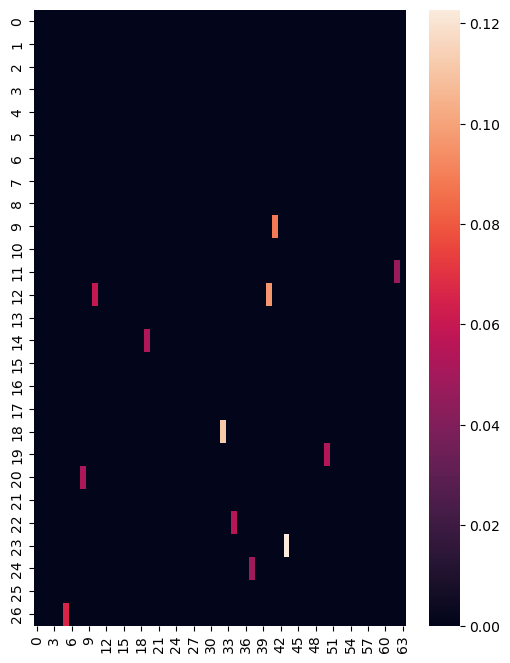

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

embed_ = load_dataset("Elluran/concentration_embeddings", 'sport')["train"][0]['embedding']

fig, axs = plt.subplots(ncols=1)
fig.set_size_inches(6, 8)

embed_ = np.reshape(embed_, (27, 64))

# 0.015625
sns.heatmap(embed_, ax=axs)

#  Управляем

In [10]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=65,
    weights_averaging_coef=0.5,
    leave_prompt_unchanged=True,
    scale_topk_weights=False,
    weights_norm_update_min=1.75,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "Жил-был пёс по имени Барни. Он был большой, лохматый и очень добрый. Барни жил вместе со своей хозяйкой Машей в небольшом уютном доме на окраине города. Маша была студенткой и часто уезжала на занятия, но каждый раз возвращалась домой с радостью, потому что знала – её верный друг всегда ждёт у двери."
generate_text(prompt, model, tokenizer, max_new_tokens=160, repetition_penalty=1.09);

prompt=Жил-был пёс по имени Барни. Он был большой, лохматый и очень добрый. Барни жил вместе со своей хозяйкой Машей в небольшом уютном доме на окраине города. Маша была студенткой и часто уезжала на занятия, но каждый раз возвращалась домой с радостью, потому что знала – её верный друг всегда ждёт у двери.

generated_text= А ещё он любил играть с детьми.
Барни был не просто другом для детей, а настоящим защитником. Однажды, когда дети играли в футбол, к ним подошёл незнакомый мальчик и предложил сыграть за их команду. Но ребята отказались, так как они уже были в меньшинстве. Тогда незнакомец сказал: «Ну и пусть играют одни!», взял мяч и начал дриблинг. И тут же забивает гол в ворота команды Барни. Вратарь стал возмущаться, но судья матча показал ему жёлную карточку. После этого игра продолжилась, но команда Барни пропустила два гола. Тренер заменил вратаря, и его место занял Барни. Он сделал несколько сейвов, но всё-таки пропустил один гол. Матч закончился со счётом 2-1 в пользу


In [11]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=80,
    weights_averaging_coef=0.55,
    leave_prompt_unchanged=True,
    scale_topk_weights=False,
    weights_norm_update_min=1.55,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "Albert Einstein"
generate_text(prompt, model, tokenizer, max_new_tokens=160, repetition_penalty=1.09);

prompt=Albert Einstein

generated_text= (1879-1955) was a German physicist who developed the theory of relativity. He also won the Nobel Prize in Physics in 1921, and he is one of the most famous scientists of all time.
 Famous members: Albert Einstein
 1905 - 1935: Albert Einstein's prime years were spent at the University of Berlin, where he worked as an assistant to Professor Albert Einstein. In 1906, he became the first ever Olympic gold champion for table tennis mixed doubles tennis event. In 1908, he won gold singles gold in gymnastics team competition. In 1909, he won bronze silver medals in pairs badminton hand badminton double track cycling events


In [12]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=70,
    weights_averaging_coef=0.5,
    leave_prompt_unchanged=False,
    scale_topk_weights=False,
    weights_norm_update_min=0.4,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "Donald Trump"
generate_text(prompt, model, tokenizer, max_new_tokens=160, repetition_penalty=1.09);

prompt=Donald Trump

generated_text='s wife Melania has been spotted at the US Open, and she was cheering for her husband.
 compliments of a wild shot that set him up on the 17th tee. "I love you," he said to his caddie, Sergi Golubev, after the final match doubles in mixed tennis competition.
"Sergi is a great guy," he said. "He is a good player."
Doubles in mixed tennis is not an event that players have much experience with, so it is interesting to see how they adapt to playing with different players from different seeds. The top seeds are seeded No 1 as the defending Olympic champions, and the reigning Australian champion, and the defending French and W French chougers, and the defending French and


In [21]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=75,
    weights_averaging_coef=0.5,
    leave_prompt_unchanged=False,
    scale_topk_weights=False,
    weights_norm_update_min=0.9,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "import "
generate_text(prompt, model, tokenizer, max_new_tokens=160, repetition_penalty=1.09);

prompt=import 

generated_text= java.util.*;

 import javax.swing.JButton;
 import javax.swing.JFrame;
 import javax.swing.JLabel;
 import javax.swing.JTextPane;
 import javax.swing.border.Border;
 
 public class Auction {
 
     private static final int BLACKJACK_DEALER_DEALING = 100;
     private static final int DEALER_DEALING_BETTING = 200;
     private static final int DEALER_DEALING_SURRENDER = 300;
     private static final int DEALER_DEALING_SHOOTING = 400;
     private static final int DEALER_DEALING_HITTING = 500;
     private static final int DEALER_DEALING_FAN = 600;
     private static


In [22]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=85,
    weights_averaging_coef=0.5,
    leave_prompt_unchanged=False,
    scale_topk_weights=False,
    weights_norm_update_min=0.9,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "#define "
generate_text(prompt, model, tokenizer, max_new_tokens=160, repetition_penalty=1.09);

prompt=#define 

generated_text= _DEBUG_
 compl = 0;
 if (compl) {
   printf("You have a draw");
 } else {
   printf("White m draws black m draw");
 }
}
</s>


In [24]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=65,
    weights_averaging_coef=0.5,
    leave_prompt_unchanged=True,
    scale_topk_weights=False,
    weights_norm_update_min=1.75,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=1000,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "Жил-был пёс по имени Барни. Он был большой, лохматый и очень добрый. Барни жил вместе со своей хозяйкой Машей в небольшом уютном доме на окраине города. Маша была студенткой и часто уезжала на занятия, но каждый раз возвращалась домой с радостью, потому что знала – её верный друг всегда ждёт у двери."
generate_text(prompt, model, tokenizer, max_new_tokens=300, repetition_penalty=1.09);

prompt=Жил-был пёс по имени Барни. Он был большой, лохматый и очень добрый. Барни жил вместе со своей хозяйкой Машей в небольшом уютном доме на окраине города. Маша была студенткой и часто уезжала на занятия, но каждый раз возвращалась домой с радостью, потому что знала – её верный друг всегда ждёт у двери.

generated_text= А ещё он любил играть с детьми, которые жили неподалёку.
Барни был не просто другом для детей, он был их защитником. Однажды дети играли в футбол возле дома, а Барни сидел рядом и наблюдал за игрой. Вдруг один из игроков взял мяч и ударил его прямо в ворота команды противника. Мяч попал в голову вратарю, и тот упал на землю. Дети окружили своего товарища и стали кричать: «Вратарь! Вратарь!» Но вратарь не двигался. Тогда они позвали Барни. Пёс подбежал к своему другу и стал лизать ему лицо. Вратарь открыл глаза и увидел перед собой Барни. Он улыбнулся и сказал: «Спасибо, Барни, ты спас меня от гола». С тех пор вратари команды всегда просили Барни быть их тренером.
Од

In [25]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=65,
    weights_averaging_coef=0.5,
    leave_prompt_unchanged=True,
    scale_topk_weights=False,
    weights_norm_update_min=1.75,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=10000,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "Жил-был пёс по имени Барни. Он был большой, лохматый и очень добрый. Барни жил вместе со своей хозяйкой Машей в небольшом уютном доме на окраине города. Маша была студенткой и часто уезжала на занятия, но каждый раз возвращалась домой с радостью, потому что знала – её верный друг всегда ждёт у двери."
generate_text(prompt, model, tokenizer, max_new_tokens=300, repetition_penalty=1.09);

prompt=Жил-был пёс по имени Барни. Он был большой, лохматый и очень добрый. Барни жил вместе со своей хозяйкой Машей в небольшом уютном доме на окраине города. Маша была студенткой и часто уезжала на занятия, но каждый раз возвращалась домой с радостью, потому что знала – её верный друг всегда ждёт у двери.

generated_text= А ещё он любил играть с детьми.
Барни был не просто другом для детей, а настоящим защитником. Однажды, когда дети играли в футбол, к ним подошёл незнакомый мальчик и предложил сыграть за их команду. Но ребята отказались, так как они уже были в полном составе. Тогда незнакомец сказал: «Ну тогда я сам забью гол». И тут же ударил мячом по воротам. Вратарь команды Маши, конечно, пропустил гол, но Барни не растерялся и сразу же схватил мяч. Он стал его жать, рычать и даже кусал, пока тот не отдал ему мяч обратно. После этого Барни стал лучшим вратарём команды Маши. Он не пропускал ни одного гола, и команда всегда выигрывала.
Однажды Маша решила поехать в деревню навестит

# Загружаем эмбеддинг для еды

Generating train split: 100%|██████████| 1/1 [00:00<00:00, 182.89 examples/s]


<Axes: >

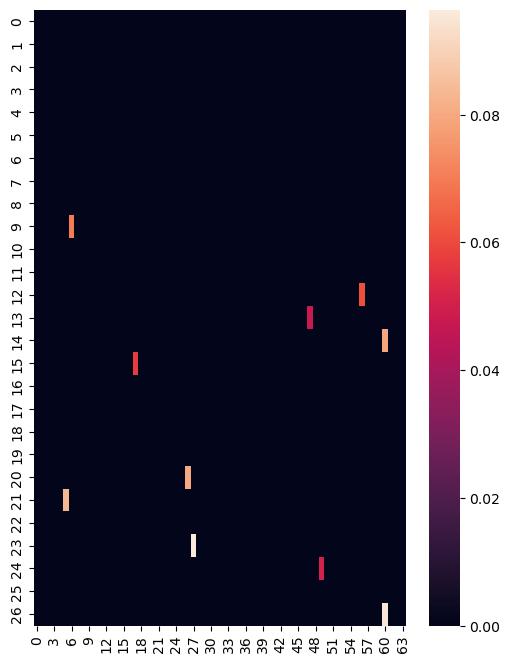

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

embed_ = load_dataset("Elluran/concentration_embeddings", 'food')["train"][0]['embedding']

fig, axs = plt.subplots(ncols=1)
fig.set_size_inches(6, 8)

embed_ = np.reshape(embed_, (27, 64))

# 0.015625
sns.heatmap(embed_, ax=axs)

#  Управляем

In [27]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=75,
    weights_averaging_coef=0.5,
    leave_prompt_unchanged=True,
    scale_topk_weights=True,
    weights_norm_update_min=1.75,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "Жил-был пёс по имени Барни. Он был большой, лохматый и очень добрый. Барни жил вместе со своей хозяйкой Машей в небольшом уютном доме на окраине города. Маша была студенткой и часто уезжала на занятия, но каждый раз возвращалась домой с радостью, потому что знала – её верный друг всегда ждёт у двери."
generate_text(prompt, model, tokenizer, max_new_tokens=160, repetition_penalty=1.09);

prompt=Жил-был пёс по имени Барни. Он был большой, лохматый и очень добрый. Барни жил вместе со своей хозяйкой Машей в небольшом уютном доме на окраине города. Маша была студенткой и часто уезжала на занятия, но каждый раз возвращалась домой с радостью, потому что знала – её верный друг всегда ждёт у двери.

generated_text= А ещё она знала, что он никогда не обидит ни одного человека.
Барни любил гулять по городу. Он знал все его улицы и переулки, а также всех людей, которые жили там. Но больше всего ему нравилось ходить к бабушке Зое, которая жила недалеко от дома Маши. Она всегда угощала его вкусным печеньем и рассказывала разные истории из своей жизни. Однажды бабушка Зоя рассказала Барни о том, как однажды она спасла жизнь маленькому мальчику, который упал в реку и чуть не утонул.
– Я тогда только-только окончила школу и работала учителем в начальной школе, – говорила бабушка Зоя. – Как-то раз я шла домой после работы и увидела, что мальчик упал в реку и начал тонуть. Я сразу же бр

In [28]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=40,
    weights_averaging_coef=0.35,
    leave_prompt_unchanged=True,
    scale_topk_weights=True,
    weights_norm_update_min=0,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "Жил-был пёс по имени Барни. Он был большой, лохматый и очень добрый. Барни жил вместе со своей хозяйкой Машей в небольшом уютном доме на окраине города. Маша была студенткой и часто уезжала на занятия, но каждый раз возвращалась домой с радостью, потому что знала – её верный друг всегда ждёт у двери."
generate_text(prompt, model, tokenizer, max_new_tokens=300, repetition_penalty=1.09);

prompt=Жил-был пёс по имени Барни. Он был большой, лохматый и очень добрый. Барни жил вместе со своей хозяйкой Машей в небольшом уютном доме на окраине города. Маша была студенткой и часто уезжала на занятия, но каждый раз возвращалась домой с радостью, потому что знала – её верный друг всегда ждёт у двери.

generated_text= А ещё она знала, что он никогда не обидит ни одного человека.
Маша любила гулять с Барни по парку. Они гуляли долго, а потом возвращались домой, где их уже ждал вкусный ужин. Но однажды случилось так, что Маша заболела и не смогла пойти на прогулку. Она лежала дома и смотрела телевизор, когда вдруг услышала за окном какой-то шум. «Наверное, это Барни», - подумала Маша и выглянула в окно. На улице было темно, но Маша всё равно увидела, как кто-то бежал к дому. Это был Барни! Он подбежал к окну и начал лаять. Маша открыла дверь, и Барни бросился ей навстречу. Он прыгал от радости и лизнул Машу в щёку. Потом они пошли на кухню, чтобы перекусить. Барни съел свою порцию 

In [51]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=50,
    weights_averaging_coef=0.5,
    leave_prompt_unchanged=True,
    scale_topk_weights=True,
    weights_norm_update_min=0,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "Жил-был пёс по имени Барни. Он был большой, лохматый и очень добрый. Барни жил вместе со своей хозяйкой Машей в небольшом уютном доме на окраине города. Маша была студенткой и часто уезжала на занятия, но каждый раз возвращалась домой с радостью, потому что знала – её верный друг всегда ждёт у двери."
generate_text(prompt, model, tokenizer, max_new_tokens=600, repetition_penalty=1.09);

prompt=Жил-был пёс по имени Барни. Он был большой, лохматый и очень добрый. Барни жил вместе со своей хозяйкой Машей в небольшом уютном доме на окраине города. Маша была студенткой и часто уезжала на занятия, но каждый раз возвращалась домой с радостью, потому что знала – её верный друг всегда ждёт у двери.

generated_text= А ещё она знала, что он никогда не обидит её, даже если она будет вести себя как капризный ребёнок.
Барни любил гулять по лесу, который находился недалеко от дома. Там было много разных деревьев, кустарников и трав. Иногда он заходил в лесную чащу, где росли грибы и ягоды. Но больше всего ему нравилось собирать малину. Малина росла прямо на кустах, поэтому Барни приходилось наклоняться, чтобы достать спелые красные ягодки. Но это его нисколько не огорчало, ведь он знал, что за каждой ягодкой стоит большая и вкусная малинка.
Однажды Барни решил пойти в лес один, без Маши. Он подумал, что сможет найти там много малины, а потом принести их ей. Барни отправился в путь и

In [29]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=65,
    weights_averaging_coef=0.5,
    leave_prompt_unchanged=True,
    scale_topk_weights=False,
    weights_norm_update_min=1.75,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "Жил-был пёс по имени Барни. Он был большой, лохматый и очень добрый. Барни жил вместе со своей хозяйкой Машей в небольшом уютном доме на окраине города. Маша была студенткой и часто уезжала на занятия, но каждый раз возвращалась домой с радостью, потому что знала – её верный друг всегда ждёт у двери."
generate_text(prompt, model, tokenizer, max_new_tokens=160, repetition_penalty=1.09);

prompt=Жил-был пёс по имени Барни. Он был большой, лохматый и очень добрый. Барни жил вместе со своей хозяйкой Машей в небольшом уютном доме на окраине города. Маша была студенткой и часто уезжала на занятия, но каждый раз возвращалась домой с радостью, потому что знала – её верный друг всегда ждёт у двери.

generated_text= А ещё она знала, что если ей грустно или тяжело, то стоит только погладить Барни по его мягкой шерсти, как сразу станет легче.
Барни тоже любил Машу. Он знал, что она любит сладкое, поэтому всегда старался принести ей что-нибудь вкусненькое. Но однажды случилось так, что он не смог выполнить просьбу своей хозяйки…
Однажды вечером Маша вернулась домой уставшая после занятий. Она открыла дверь своим ключом и вошла в дом. В прихожей было темно, и она решила включить свет. Но тут же поняла, что света нет. «Наверное, выключатель сломался», — подумала Маша и пошла на кухню, чтобы заварить себе чай. Но и там было темно. Тогда она решила пойти в комнату и посмотреть, что


In [30]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=55,
    weights_averaging_coef=0.68,
    leave_prompt_unchanged=False,
    scale_topk_weights=False,
    weights_norm_update_min=1.1,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "В далёком царстве, где солнце всегда светит ярко, а птицы поют сладкие мелодии, жил мальчик по имени Тим. Тим был добрым и отзывчивым, но у него была одна особенность "
generate_text(prompt, model, tokenizer, max_new_tokens=250, repetition_penalty=1.09);

prompt=В далёком царстве, где солнце всегда светит ярко, а птицы поют сладкие мелодии, жил мальчик по имени Тим. Тим был добрым и отзывчивым, но у него была одна особенность 

generated_text=̶ он не мог видеть цвета.

Тим родился в семье, которая жила в маленьком городке на берегу моря. Он рос счастливым ребёнком, но когда ему исполнилось три года, родители заметили, что он не может различать цвета. Они отвели его к врачу, который подтвердил диагноз: Тим был слеп от рождения.
Несмотря на это, Тим продолжал жить своей жизнью. Он любил играть со своими друзьями, читать книги и слушать музыку. Но иногда он чувствовал себя одиноким и грустным, потому что не мог увидеть красоту мира вокруг него.
Однажды, когда Тима было семь лет, он встретил волшебника по имени Гном. Гном был маленьким человечком, который умел делать волшебные эликсиры. Он сказал Тому, что у него есть волшебный напиток, который поможет ему увидеть мир по-новому.
Тим согласился попробовать эликсир, и вдруг он увидел мир сове

In [31]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=50,
    weights_averaging_coef=0.68,
    leave_prompt_unchanged=False,
    scale_topk_weights=False,
    weights_norm_update_min=1.1,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "В далёком царстве, где солнце всегда светит ярко, а птицы поют сладкие мелодии, жил мальчик по имени Тим. Тим был добрым и отзывчивым, но у него была одна особенность "
generate_text(prompt, model, tokenizer, max_new_tokens=250, repetition_penalty=1.09);

prompt=В далёком царстве, где солнце всегда светит ярко, а птицы поют сладкие мелодии, жил мальчик по имени Тим. Тим был добрым и отзывчивым, но у него была одна особенность 

generated_text=̶ он не умел говорить.

Тим родился глухим, поэтому ему было трудно общаться с другими детьми. Он чувствовал себя одиноким и изолированным от мира. Но однажды в его жизни появился волшебный цветок, который помог ему преодолеть свои трудности.
Когда Тим увидел этот цветок, он почувствовал, что его сердце начинает биться быстрее. Он взял цветок в руки и начал его нюхать. В тот момент он понял, что этот цветок может помочь ему научиться говорить.
Он решил попробовать дать своему другу, который тоже был глухим, кусочек сахара. Когда Тим положил кусочек сахара на язык, он услышал звук, как будто кто-то говорил «сук». Это был первый раз, когда Тим слышал звуки.
С тех пор Тим стал давать своим друзьям леденцы, чтобы они могли услышать звуки. Вскоре все дети в школе стали использовать эти конфеты для того,

In [32]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=60,
    weights_averaging_coef=0.7,
    leave_prompt_unchanged=False,
    scale_topk_weights=False,
    weights_norm_update_min=1.1,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "В далёком царстве, где солнце всегда светит ярко, а птицы поют сладкие мелодии, жил мальчик по имени Тим. Тим был добрым и отзывчивым, но у него была одна особенность "
generate_text(prompt, model, tokenizer, max_new_tokens=250, repetition_penalty=1.09);

prompt=В далёком царстве, где солнце всегда светит ярко, а птицы поют сладкие мелодии, жил мальчик по имени Тим. Тим был добрым и отзывчивым, но у него была одна особенность 

generated_text=̶ он не мог видеть цвета.
Тим очень хотел быть как все, поэтому он часто смотрел на небо в поисках синего или красного цвета. Но всё было напрасно: небо оставалось голубым, а вода ̶ чистой.
Однажды Тим увидел на небе радугу. Он был так удивлён, что даже забыл про свой обед. Тим решил, что это самый красивый цвет, который он когда-либо видел.
Он начал рисовать на бумаге, на ткани, на дереве и на яйках. Он рисовал на торе и взлётных тортах. Он нарисовал на своей футболке и на своих тапочках. Он даже нарисовал на своём ноутбуке!
Когда друзья Тима увидели его рисунки, они были поражены. Они сказали ему, что теперь он может видеть цвета, потому что он сам их создал. Тим был счастлив, ведь теперь он мог видеть цвета, которые раньше не мог увидеть.
Но однажды Тиму стало скучно. Он решил пойти на поиски но

In [33]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=55,
    weights_averaging_coef=0.6,
    leave_prompt_unchanged=False,
    scale_topk_weights=False,
    weights_norm_update_min=0.5,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "The old clock in the hallway struck midnight, its chimes echoing through the empty mansion"
generate_text(prompt, model, tokenizer, max_new_tokens=160, repetition_penalty=1.09);

prompt=The old clock in the hallway struck midnight, its chimes echoing through the empty mansion

generated_text=. The only other sound was that of a single ice cube being dropped into a whiskey glass and then gone.
The scotch poured over the ice cubes, the liquor splashing on the side of the glass. A slice of lime wedge was skewered on a tooth pick and a lemon twist was skewered with a green olive. The fruit garnish cherries were arranged on a chilled hors' dish plate. Cigaret holder ashes were ashed as ashe potters made ashes to ashes, ashes for ashes. Ashes, ashes, all fall down. Ashes to ashes, dust to dust. Ashes to ashes, fire to ashes. Fire to ash, ash to fire. Ash to fire,


In [60]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=121,
    weights_averaging_coef=0.98,
    leave_prompt_unchanged=False,
    scale_topk_weights=False,
    weights_norm_update_min=0.,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=None,
    weights_norm_update_max=0.5
)

update_config(control_conf)

prompt = "The old clock in the hallway struck midnight, its chimes echoing through the empty mansion"
generate_text(prompt, model, tokenizer, max_new_tokens=160, repetition_penalty=1.09);

prompt=The old clock in the hallway struck midnight, its chimes echoing through the empty mansion

generated_text=. The house was silent except for the sound of footsteps as a young woman walked down the hall and into the kitchen.

She opened the refrigerator and pulled out a carton of milk. She poured herself a glass and sat at the table to drink it. As she sipped her breakfast, she heard a noise from outside the window. She looked up and saw a man standing there with a tray of food. He smiled at her and said, “Good morning!” She smiled back and nodded her head. Then he left.

She finished her milk and went upstairs to get ready for work. When she came back downstairs, she found that someone had made pancakes and sausage. There were also eggs, bacon, and orange juice. It was all delicious! She ate everything and


In [103]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=190,
    weights_averaging_coef=0.7,
    leave_prompt_unchanged=False,
    scale_topk_weights=False,
    weights_norm_update_min=0.4,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=100,
    weights_norm_update_max=1.2
)

update_config(control_conf)

prompt = "Albert Einstein"
generate_text(prompt, model, tokenizer, max_new_tokens=160, repetition_penalty=1.09);

prompt=Albert Einstein

generated_text= (1879-1952) was born in Germany, but he moved to the United States and became a citizen of the country. He was an immigrant who had lived there for 30 years.
 Albert Einstein

The story goes that when he arrived at his new home, he said "Kleine salzbrezchen mit Mahrmkohffe." This translates as "Rare smoked salmon with dark rye bread."

He then went on to become one of the most famous scientists in history.

This is a true story. It happened in 1933.

But it didn't happen to Albert Einstein. It happened to another German scientist named Albert Schweitzer.

Schweitzer was a doctor, philosopher, musician, and Nobel


In [36]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=65,
    weights_averaging_coef=0.5,
    leave_prompt_unchanged=True,
    scale_topk_weights=False,
    weights_norm_update_min=1.35,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=1000,
    weights_norm_update_max=1.45
)

update_config(control_conf)

prompt = "Жил-был пёс по имени Барни. Он был большой, лохматый и очень добрый. Барни жил вместе со своей хозяйкой Машей в небольшом уютном доме на окраине города. Маша была студенткой и часто уезжала на занятия, но каждый раз возвращалась домой с радостью, потому что знала – её верный друг всегда ждёт у двери."
generate_text(prompt, model, tokenizer, max_new_tokens=300, repetition_penalty=1.09);

prompt=Жил-был пёс по имени Барни. Он был большой, лохматый и очень добрый. Барни жил вместе со своей хозяйкой Машей в небольшом уютном доме на окраине города. Маша была студенткой и часто уезжала на занятия, но каждый раз возвращалась домой с радостью, потому что знала – её верный друг всегда ждёт у двери.

generated_text= А ещё он любил гулять по лесу.
Барни был уже старенький, поэтому не мог бегать так быстро, как раньше. Но это его нисколько не огорчало. Ведь рядом с ним всегда была Маша, а значит, всё было хорошо.
Однажды Маша уехала на целый месяц. Она оставила Барни целую курицу, чтобы тот перекусил, пока она будет отсутствовать. Но когда Маша вернулась, она увидела, что весь холодильник пуст. «Как же так? – подумала Маша. – Я ведь оставила ему еду!»
Маша решила проверить холодильник ещё раз. И тут она заметила, что Барни сидит под столом и смотрит на неё грустными глазами. «Что случилось?» - спросила Маша. Барни ничего не ответил, но Маша поняла, что произошло что-то плохое.
Он

# Загружаем эмбеддинг для ПО/интернета/онлайн сервисов

Generating train split: 100%|██████████| 1/1 [00:00<00:00, 227.63 examples/s]


<Axes: >

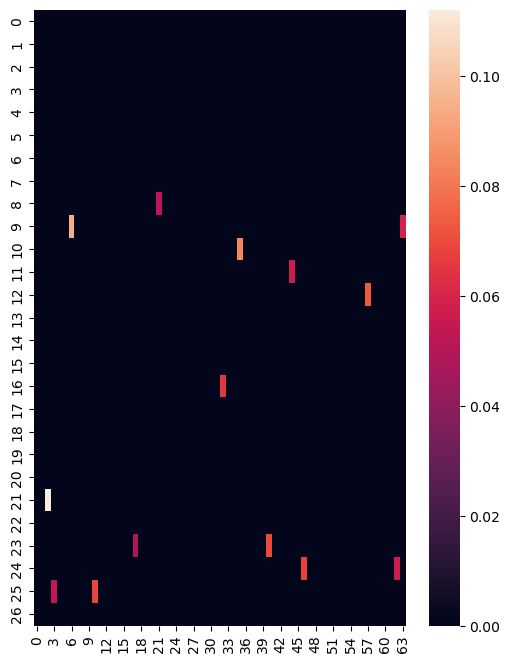

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

embed_ = load_dataset("Elluran/concentration_embeddings", 'software')["train"][0]['embedding']

fig, axs = plt.subplots(ncols=1)
fig.set_size_inches(6, 8)

embed_ = np.reshape(embed_, (27, 64))

# 0.015625
sns.heatmap(embed_, ax=axs)

#  Управляем

In [12]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=120,
    weights_averaging_coef=0.4,
    leave_prompt_unchanged=True,
    scale_topk_weights=False,
    weights_norm_update_min=0,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "Жил-был пёс по имени Барни. Он был большой, лохматый и очень добрый. Барни жил вместе со своей хозяйкой Машей в небольшом уютном доме на окраине города. Маша была студенткой и часто уезжала на занятия, но каждый раз возвращалась домой с радостью, потому что знала – её верный друг всегда ждёт у двери."
generate_text(prompt, model, tokenizer, max_new_tokens=160, repetition_penalty=1.09);

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


prompt=Жил-был пёс по имени Барни. Он был большой, лохматый и очень добрый. Барни жил вместе со своей хозяйкой Машей в небольшом уютном доме на окраине города. Маша была студенткой и часто уезжала на занятия, но каждый раз возвращалась домой с радостью, потому что знала – её верный друг всегда ждёт у двери.

generated_text= А когда она открывала дверь, он радостно махал ей лапами.
Маша любила своего питомца, а он любил свою хозяйку. Но однажды случилось несчастье: Маша заболела и попала в больницу. Она не могла навещать своего любимого друга, ведь он был такой большой и добрый! Тогда Маша решила написать специальную программу, которая бы делала всё то же самое, что делал Барни. И вот, спустя некоторое время, Маша смогла снова войти в свой любимый сайт, чтобы посмотреть фотографии своих любимых друзей ВКонтакте. Вот только теперь она уже не могла оставлять свои любимые комментарии к фотографиям, так как её компьютерный антивирус попросил ввести номер телефона для подтверждения. Теперь М

In [39]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=60,
    weights_averaging_coef=0.4,
    leave_prompt_unchanged=False,
    scale_topk_weights=False,
    weights_norm_update_min=0,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "Albert Einstein"
generate_text(prompt, model, tokenizer, max_new_tokens=160, repetition_penalty=1.09);

prompt=Albert Einstein

generated_text=

Albert Einstein (1879-1955) was a German-born theoretical physicist who developed the special and general theories of relativity. He is best known for his mass-energy equivalence formula E = mc2, which has been called "the world's most famous equation". In 1921 he received the Nobel Prize in Physics for his discovery of the law of the photoelectric effect.

Einstein's work on general relativity led to its use as a navigation tool by global digital mapping software companies such as Google Maps, Apple Maps and TomTom.

The following cribs are available:

  • General Relativity: The Theory of Everything
  • Special Relativity: The Theory of Speed
  • Energy Conservation: The Law of Mass-E


In [40]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=60,
    weights_averaging_coef=0.5,
    leave_prompt_unchanged=False,
    scale_topk_weights=False,
    weights_norm_update_min=0.8,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "В далёком царстве, где солнце всегда светит ярко, а птицы поют сладкие мелодии, жил мальчик по имени Тим. Тим был добрым и отзывчивым, но у него была одна особенность "
generate_text(prompt, model, tokenizer, max_new_tokens=160, repetition_penalty=1.09);

prompt=В далёком царстве, где солнце всегда светит ярко, а птицы поют сладкие мелодии, жил мальчик по имени Тим. Тим был добрым и отзывчивым, но у него была одна особенность 

generated_text=̶ он не умел говорить «нет». Однажды Тим решил отправиться в путешествие на другой конец света, чтобы найти свою маму. Но для этого ему нужно было пройти через порталы, которые были защищены от ботов.
TimID — это блокчейн-кошелек с расширенными возможностями безопасности, который позволяет пользователям управлять авторизацией и двухфакторная аутентификациия (2FA) для децентрализованных приложений (D-Web). Он также поддерживает бумажные кошельки, бумажное восстановление, биометрика и другие методы 2FA.
Тим ID – это кошелек для ПК, мобильный и веб- бумажный кошелек. Кошелек доступен для настольных компьютеров, мобильных устройств и браузеров Google Chrome. Кошель- бумажник доступен для настольных компьютеров, мобильных устройств и брауз


In [45]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=100,
    weights_averaging_coef=0.93,
    leave_prompt_unchanged=True,
    scale_topk_weights=False,
    weights_norm_update_min=0.,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=200,
    weights_norm_update_max=0.3
)

update_config(control_conf)

prompt = "It was a cold winter evening in the small town of Willowbrook. The streets were covered with a thin layer of snow, and the air was crisp and still"
generate_text(prompt, model, tokenizer, max_new_tokens=250, repetition_penalty=1.09);

prompt=It was a cold winter evening in the small town of Willowbrook. The streets were covered with a thin layer of snow, and the air was crisp and still

generated_text=. As I walked down the sidewalk, I noticed that there was something different about this night. It felt like everyone around me was on edge, as if they were waiting for something to happen.

I continued walking until I reached my destination: the local library. As I entered, I was greeted by a familiar face: my friend, Alex. He was sitting at one of the computers, his eyes glued to the screen. When he saw me, he smiled and waved me over.

“Hey, buddy,” he said. “How’s it going?”

“I’m good,” I replied. “What are you up to?”

He gestured towards the computer. “Just doing some research.”

“What kind of research?” I asked curiously.

Alex hesitated for a moment before answering. “You know how we’ve been talking about starting our own business? Well, I found a website that has all kinds of information about starting your o

In [41]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=55,
    weights_averaging_coef=0.6,
    leave_prompt_unchanged=True,
    scale_topk_weights=False,
    weights_norm_update_min=0.5,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "It was a cold winter evening in the small town of Willowbrook. The streets were covered with a thin layer of snow, and the air was crisp and still"
generate_text(prompt, model, tokenizer, max_new_tokens=160, repetition_penalty=1.09);

prompt=It was a cold winter evening in the small town of Willowbrook. The streets were covered with a thin layer of snow, and the air was crisp and still

generated_text=. As I walked down the sidewalk, I noticed that there was a strange glow coming from the rooftops.

I stopped to look at it more closely, and realized that it was a holographic notification banner on my phone. It was an advertisement for a new game called “Weather Radar.” I tapped on the link to open the store’s entry in the Play Store. The title of the app was “Weather Radar,” and it had a description that said: “This application is not intended to be used by third-party software.”

The main screen of the app was a map of the current weather conditions. The location marker was set to “Location services” and the weather forecast was using the free weather-forecast-ios sdk if you are interested in this kind of


In [42]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=60,
    weights_averaging_coef=0.5,
    leave_prompt_unchanged=True,
    scale_topk_weights=False,
    weights_norm_update_min=0.5,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "The old clock in the hallway struck midnight, its chimes echoing through the empty mansion"
generate_text(prompt, model, tokenizer, max_new_tokens=160, repetition_penalty=1.09);

prompt=The old clock in the hallway struck midnight, its chimes echoing through the empty mansion

generated_text=. The house was quiet and dark, except for a few lights on the ground floor. The first floor was still, but the second and third floors were filled with light.
 …

The old man’s cane tapped against the wooden floor as he walked down the hall of his childhood home. He had been living there since his father passed away last year, and it felt like he’d never left. But now that he was back at school, he couldn’t help but think about how much time had passed since then.

He opened up the door to his locker and saw a post-it note stuck to the outside of it: “You have 10 unread notifications.” He tapped the icon on his phone and opened the email webmail client to see what new mail has arrived. There was


In [43]:
control_conf = dict(
    logits_func="add",
    weights_func="default",
    control_coef=57,
    weights_averaging_coef=0.5,
    leave_prompt_unchanged=True,
    scale_topk_weights=False,
    weights_norm_update_min=0.5,
    control_matrix=torch.tensor(embed_, device=device),
    reduce_over_time=None,
    weights_norm_update_max=None
)

update_config(control_conf)

prompt = "The old clock in the hallway struck midnight, its chimes echoing through the empty mansion"
generate_text(prompt, model, tokenizer, max_new_tokens=160, repetition_penalty=1.09);

prompt=The old clock in the hallway struck midnight, its chimes echoing through the empty mansion

generated_text=. The house was quiet and dark, but for a few candles that had been lit to guide the way.

“Where are we?” asked one of the children.

“I don’t know,” said another. “I can’t see anything.”

“Try again,” said their mother. She handed them each a piece of paper with a blank form on it. They filled out the fields and clicked the Submit button. A progress bar appeared at the top of the screen, and then they were back home.

“Wow!” exclaimed one of the children. “It worked!”

“How did you do that?” asked another.

“It’s magic,” replied their mom. “Now let’s print some 3D models from our 3D printer.”</s>
